# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Task Description

I need to predict the price of a used cars based on its features. Obviously, this is a regression problem. As a control metric, I will choose Mean Absolute Percentage Error (MAPE). It is the mean of all absolute percentage errors between the predicted and actual values.
It both easy for end users to understand and simpler to compare model accuracy across use cases and datasets. 

Since the target is the price of a car in the hundreds of thousands of rubles, these values are far from 0, so I can use this metric without worrying about dividing by 0 when calculating the metric.

# Overview

In [210]:
data = pd.read_csv('data/data.csv')
data.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,views,date_added,region,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"['cruise-control', 'multi-wheel', 'xenon', 'he...",Автомобиль приобретался у официального дилера ...,1.8 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,162026.0,2013.0,NaN,Octavia,Skoda Octavia III (A7),5.0,1.632613e+09,RUB,2015.0,1.105111e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK ROBOT 1.8,роботизированная,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,76.0,24 сентября,в Тюмени,999000.0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",Группа компаний Элан Моторс официальный дилер ...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,https://autoru.naydex.net/9OmUme448/624f74NbAb...,19210.0,2020.0,NaN,Rapid,Skoda Rapid II,5.0,1.632613e+09,RUB,2020.0,1.104819e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK AUTOMATIC 1.6,автоматическая,NaN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,259.0,24 сентября,в Санкт-Петербурге,1179000.0
2,лифтбек,SKODA,https://auto.ru/cars/new/group/skoda/rapid/217...,белый,"['cruise-control', 'heated-wash-system', 'airb...",Специальные предложения на автомобили в наличи...,1.6 LTR,90 N12,"{'cruise-control': True, 'glonass': True, 'esp...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,NaN,2020.0,NaN,NaN,Skoda Rapid II,5.0,1.632613e+09,RUB,2021.0,1.104778e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK MECHANICAL 1.6,механическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1464100.0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"['cruise-control', 'multi-wheel', 'heated-wash...",Купим Ваш автомобиль ДОРОГО Гарантированная с...,1.4 LTR,150 N12,"{'cruise-control': True, 'esp': True, 'usb': T...",бензин,https://autoru.naydex.net/9OmUme448/624f74NbAb...,52400.0,2017.0,NaN,Octavia,Skoda Octavia III (A7) Рестайлинг,5.0,1.632613e+09,RUB,2018.0,1.105205e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK ROBOT 1.4,роботизированная,NaN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,31.0,25 сентября,в Тюмени,1420000.0
4,внедорожник 5 дв.,SKODA,https://auto.ru/cars/new/group/skoda/karoq/217...,серый,"['cruise-control', 'multi-wheel', 'heated-wash...",ЛОТ 01267595 Скидка на автомобиль при покупке ...,1.4 LTR,150 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,https://autoru.naydex.net/9OmUme448/624f74NbAb...,NaN,2017.0,NaN,NaN,Skoda Karoq I,5.0,1.632613e+09,RUB,2021.0,1.105298e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 1.4,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2653190.0


In [211]:
data.shape

(130201, 36)

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130201 entries, 0 to 130200
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              129986 non-null  object 
 1   brand                 129988 non-null  object 
 2   car_url               129969 non-null  object 
 3   color                 129988 non-null  object 
 4   complectation_dict    105267 non-null  object 
 5   description           129988 non-null  object 
 6   engineDisplacement    129988 non-null  object 
 7   enginePower           129988 non-null  object 
 8   equipment_dict        129969 non-null  object 
 9   fuelType              129986 non-null  object 
 10  image                 130065 non-null  object 
 11  mileage               103034 non-null  float64
 12  modelDate             129986 non-null  float64
 13  model_info            0 non-null       float64
 14  model_name            103034 non-null  object 
 15  

In [213]:
data.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'views', 'date_added',
       'region', 'price'],
      dtype='object')

In [214]:
data.isnull().sum()

bodyType                   215
brand                      213
car_url                    232
color                      213
complectation_dict       24934
description                213
engineDisplacement         213
enginePower                213
equipment_dict             232
fuelType                   215
image                      136
mileage                  27167
modelDate                  215
model_info              130201
model_name               27167
name                        48
numberOfDoors              214
parsing_unixtime            47
priceCurrency               48
productionDate             213
sell_id                    232
super_gen                   66
vehicleConfiguration       214
vehicleTransmission        215
vendor                  130201
Владельцы                27167
Владение                115915
ПТС                      27167
Привод                   27169
Руль                     27168
Состояние                27169
Таможня                  27171
views   

In [215]:
data.describe()

,mileage,modelDate,model_info,numberOfDoors,parsing_unixtime,productionDate,sell_id,vendor,views,price
count,103034.000000,129986.000000,0.0,129987.000000,1.301540e+05,129988.000000,1.299690e+05,0.0,101998.000000,1.097650e+05
mean,116610.915407,2012.934578,NaN,4.643164,1.632842e+09,2015.083854,1.104866e+09,NaN,564.982284,2.801223e+06
std,85154.492046,6.017749,NaN,0.619354,1.316360e+05,5.929774,1.779786e+06,NaN,1814.036025,2.689068e+06
min,1.000000,1938.000000,NaN,2.000000,1.632613e+09,1952.000000,1.003139e+09,NaN,2.000000,2.300000e+04
25%,51000.000000,2010.000000,NaN,4.000000,1.632725e+09,2012.000000,1.104900e+09,NaN,127.000000,1.000000e+06
50%,100000.000000,2014.000000,NaN,5.000000,1.632821e+09,2016.000000,1.105219e+09,NaN,245.000000,2.045000e+06
75%,161000.000000,2017.000000,NaN,5.000000,1.632973e+09,2020.000000,1.105376e+09,NaN,511.000000,3.649000e+06
max,1000000.000000,2021.000000,NaN,5.000000,1.633049e+09,2021.000000,1.105403e+09,NaN,148149.000000,3.999000e+07


### Subtotal

- There are 130201 rows in this dataset.
- Target "price" contains 20436 missing values. It's bad, because I can't use this examples for model training, so I will remove them.
- Here a lot of categorical features, like as fuelType, brand, color and so on.
- There are description of announcement. It is text data and interesting, will I extract any valuable information from this feature.
- Here two features with links - car_url and image. I will not analyze image links because I will not work with CV techniques in this project. Also I will not use car_url, because I have already a good list of parameters for every case.
- complectation_dict - this feature contains useful information (for example, 'cruise-control', 'multi-wheel' and so on). Moreover, some parameters from this feature are duplicated in the main dataset. Next, I will analyze this feature in more detail.

# Data Preprocessing

In [216]:
# Deleting rows with missing values in target
data = data[data['price'].notna()].reset_index(drop=True)

In [217]:
# Let's remove (little bit later) model_info and vendor features, because they are empty
print(data['model_info'].isna().sum())
print(data['vendor'].isna().sum())

109765
109765


In [218]:
# Data has downloaded in one session. So let's check first value in parsing_unixtime column.
# Date of data parsing is 2021-09-26 
print(data['parsing_unixtime'][0])

1632613481.0


In [219]:
# Feature priceCurrency is constant. Let's remove it
print(data['priceCurrency'].value_counts())

RUB    109765
Name: priceCurrency, dtype: int64


In [220]:
# This feature is unnecessary, because dataset already has this content (body type, transmission, engine displacement). 
# Let's remove it
print(data['vehicleConfiguration'])

0                    LIFTBACK ROBOT 1.8
1                LIFTBACK AUTOMATIC 1.6
2               LIFTBACK MECHANICAL 1.6
3                    LIFTBACK ROBOT 1.4
4         ALLROAD_5_DOORS AUTOMATIC 1.4
                      ...              
109760             SEDAN MECHANICAL 2.0
109761     ALLROAD_5_DOORS VARIATOR 2.4
109762     ALLROAD_5_DOORS VARIATOR 2.0
109763     ALLROAD_5_DOORS VARIATOR 2.4
109764             SEDAN MECHANICAL 1.6
Name: vehicleConfiguration, Length: 109765, dtype: object


In [221]:
# Let's remove this feature, because missing values qty > 88%
print(data['Владение'].isna().sum())
print(f'Missing values qty: {round((data.Владение.isna().sum() / len(data)) * 100, 2)}%')

97597
Missing values qty: 88.91%


In [222]:
# Let's remove this feature, because it contains only one constant value and missing values
print(data['Состояние'].isna().sum())
print(data['Состояние'].value_counts())

21153
Не требует ремонта    88612
Name: Состояние, dtype: int64


In [223]:
# Let's remove this feature, because it contains only one constant value and missing values
print(data['Таможня'].isna().sum())
print(data['Таможня'].value_counts())

21156
Растаможен    88609
Name: Таможня, dtype: int64


In [224]:
# Deleting unnecessary features 
data = data.drop(columns=['car_url', 'image', 'model_info', 'vendor', 'parsing_unixtime', 'priceCurrency', 'vehicleConfiguration', 
                          'Владение', 'Таможня', 'Состояние'])

In [242]:
data.columns = ['body_type', 'brand', 'color', 'complectation_dict', 'description',
                'engine_displacement', 'engine_power', 'equipment_dict', 'fuel_type',
                'mileage', 'model_date', 'model_name', 'name', 'doors_number',
                'production_date', 'sell_id', 'super_gen', 'vehicle_transmission',
                'owners', 'vehicle_passport', 'wheel_drive', 'steering_wheel', 'views', 
                'date_added', 'region', 'price']

### Target - Price

<AxesSubplot:xlabel='price', ylabel='Density'>

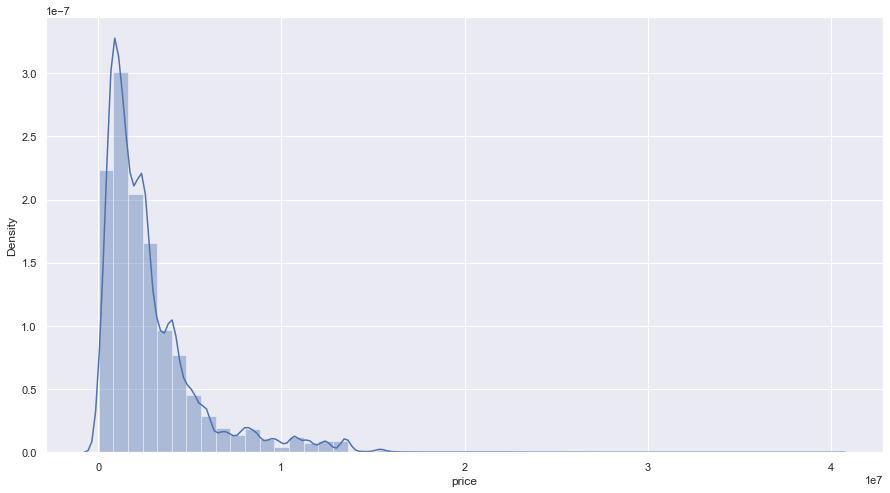

In [248]:
f, ax = plt.subplots(figsize=(15,8))
sns.distplot(data['price'])